# Setting up data

In [2]:
# collaborative filtering: user provides ratings about an item (ex. movie ratings)
# tend ot leverage inter-item or inter-user correlations for imputations

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import statistics
import collections

In [4]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366538 sha256=92c3e8d24167aa5af128276df2d92c595fc086db5776a8e7d738b5cb99e5a326
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [59]:
import surprise
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection.split import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF

In [60]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [61]:
from sklearn.metrics import mean_squared_error

In [7]:
# columns that contain commas (',') are escaped using double-quotes ('"')
# files are encoded as UTF-8

# user IDs consistent between ratings.csv and tags.csv
# movie ids are consistent between ratings.csv, tags.csv, movies.csv, links,csv
    # IDs are the URL for MovieLens

# ratings.csv
    # one rating of one movie by one user
    # userId, movieID, rating, timestamp
        # ratings are on 5-star scale with half-star increments

# tags.csv
    # usrId, movieIs, tag, timestamp
        # tags are user-generated metadata about movies (single word or short phrase)

# movies.csv
    # movieId,title,genres
    # genres:
"""
    * Action
    * Adventure
    * Animation
    * Children's
    * Comedy
    * Crime
    * Documentary
    * Drama
    * Fantasy
    * Film-Noir
    * Horror
    * Musical
    * Mystery
    * Romance
    * Sci-Fi
    * Thriller
    * War
    * Western
    * (no genres listed)
"""

# links.csv
    # movieId,imdbId,tmdbId
        # links for the movies on separate sites

"\n    * Action\n    * Adventure\n    * Animation\n    * Children's\n    * Comedy\n    * Crime\n    * Documentary\n    * Drama\n    * Fantasy\n    * Film-Noir\n    * Horror\n    * Musical\n    * Mystery\n    * Romance\n    * Sci-Fi\n    * Thriller\n    * War\n    * Western\n    * (no genres listed)\n"

In [8]:
# ratings matrix = R 
    # m x n matrix
    # m = users (row)
    # n = movies (columns)
    # r_(i,j) = the rating by user i for movie j

# from github
#url = 'https://raw.githubusercontent.com/sarahwilen/EC-219/main/Project%203/ratings.csv?token=GHSAT0AAAAAAB5KQNMF3CTHNPNATAJT6AIIY7RKX3A'
#ratings = pd.read_csv(url)

from google.colab import files
uploaded = files.upload()

import io
ratings = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving ratings.csv to ratings.csv


In [9]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [10]:
ratings.dtypes

Unnamed: 0      int64
userId          int64
movieId         int64
rating        float64
timestamp       int64
dtype: object

In [11]:
ratings.shape

(100836, 5)

In [12]:
ratings.sort_values(by=['userId'])

,Unnamed: 0,userId,movieId,rating,timestamp
3700,3700,1,6,4.5,964982224
35106,35106,1,500,3.0,964981208
41885,41885,1,356,4.0,964980962
20190,20190,1,2478,4.0,964984169
23472,23472,1,1777,4.0,964981230
...,...,...,...,...,...
75641,75641,610,7894,3.5,1479544798
69809,69809,610,59022,4.0,1493846893
54751,54751,610,904,5.0,1493850276
4193,4193,610,100163,3.0,1493847984


In [13]:
user_id = ratings['userId'].values
movie_id = ratings['movieId'].values
rating = ratings['rating'].values

# Question 1

## Question 1a

In [ ]:
print("Number of ratings:" + str(rating.size))
print("Number of users: " + str(len(np.unique(user_id)))) 
print("Number of movies: " + str(len(np.unique(movie_id))))

Number of ratings:100836
Number of users: 610
Number of movies: 9724


In [ ]:
# compute the sparsity
    # total number of possible ratings = each user rating each movie

numRatings = rating.size
numUsers = len(np.unique(user_id))
numMovies = len(np.unique(movie_id))
sparsity = numRatings / (numUsers*numMovies)

print("Sparsity: " + str(sparsity))

Sparsity: 0.016999683055613623


## Question 1b

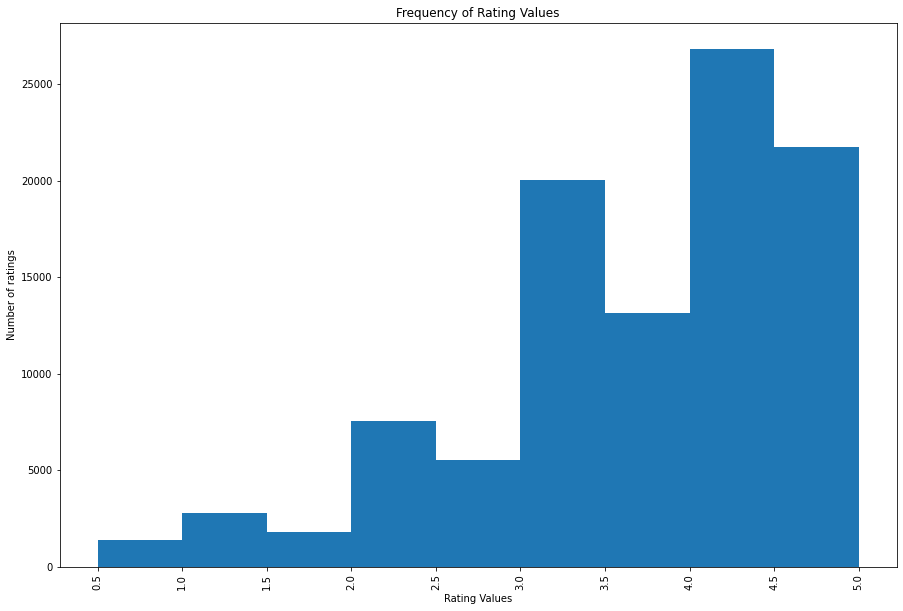

In [ ]:
# histogram: frequency of the rating values
    # bin raw rating into intervals of width 0.5
    # use binned rating values as the horizontal axis
    # the height of the vertical axis is the number of ratings that fall within each bin

n_bins = np.arange(min(rating), max(rating) + 0.5, step=0.5)
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(rating, n_bins)
plt.xticks(n_bins, rotation=90)
plt.title("Frequency of Rating Values")
plt.xlabel("Rating Values")
plt.ylabel("Number of ratings")
plt.show()

## Question 1c

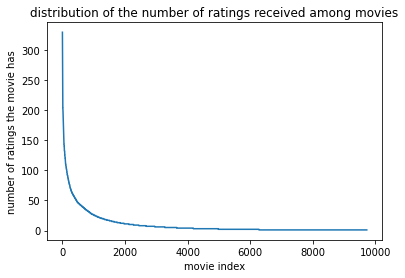

In [ ]:
# distribution of the number of ratings received among movies
    # x-axis: movie index (decreasing frequency)
    # y-axis: number of ratings the movie has 
    
movieRatingCounts = Counter(movie_id)
num_ratings = sorted(list(movieRatingCounts.values()), reverse=True)
plt.plot(num_ratings)
plt.xlabel("movie index")
plt.ylabel("number of ratings the movie has")
plt.title("distribution of the number of ratings received among movies")
plt.show()

## Question 1d

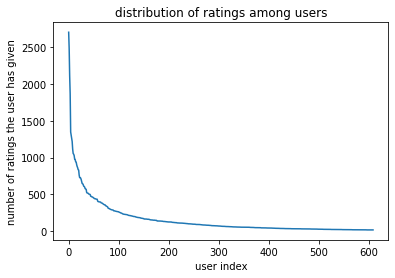

In [ ]:
# plot distirbution of ratings among users
    # x-axis: user index (decreasing frequency)
    # y-axis: number of movies the user rated

    
userCounts = Counter(user_id)
user_ratings = sorted(list(userCounts.values()), reverse=True)
plt.plot(user_ratings)
plt.xlabel("user index")
plt.ylabel("number of ratings the user has given")
plt.title("distribution of ratings among users")
plt.show()

## Question 1f

In [ ]:
# variance of rating values received by each movie
    # bin variance into width 0.5
    # horizontal axis = binned variance
    # vertical axis = # of movies with variance values of the interval

varList = []
for movie in np.unique(movie_id):
  byMovieID = ratings.loc[ratings['movieId'] == movie]
  varList.append(np.var(byMovieID['rating']))

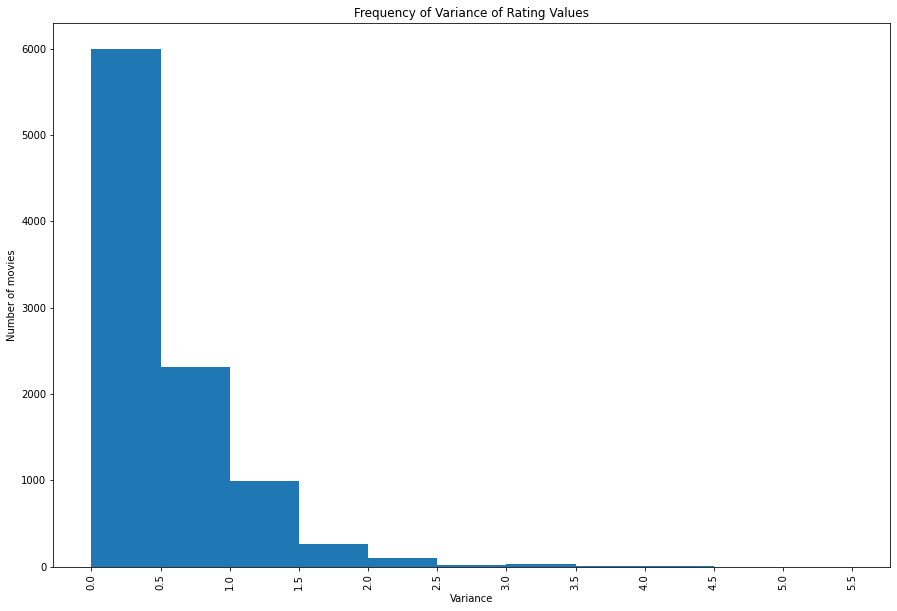

In [ ]:
n_bins = np.arange(min(varList), max(varList) + 0.5, step=0.5)
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(varList, n_bins)
plt.xticks(n_bins, rotation=90)
plt.title("Frequency of Variance of Rating Values")
plt.xlabel("Variance")
plt.ylabel("Number of movies")
plt.show()

In [ ]:
np.unique(rating)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

# Question 4

In [ ]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [14]:
ratings = ratings.drop(columns=["Unnamed: 0", "timestamp"])

In [19]:
ratings

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5
...,...,...,...
100831,469,1219,4.0
100832,599,3571,2.0
100833,414,276,3.0
100834,395,168,3.0


In [ ]:
k = range(2,100+1, 2)
avg_rmse = []
avg_mae = []

# design a KNN collab filter to predict ratings of movies
    # use pearson-correlation as the similarity metric
    # evaluate performance using 10-fold cross validation 
    # sweep k from [2,100] in step sizes of 2
    # for each k: compute average RMSE and average MAE (average across 10 folds)

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(ratings, reader=reader)

In [ ]:
for neighbors in k:
  print("\nK" + str(neighbors))

  pearsonKNN = KNNWithMeans(k=neighbors, sim_options=pearson_Sim, verbose=False) # with means centers around means

  cvKNN = cross_validate(pearsonKNN, data=ratings_data,  measures=['rmse', 'mae'], cv=10, return_train_measures=False, verbose=True)
  avg_rmse.append(np.mean(cvKNN['test_rmse']))
  avg_mae.append(np.mean(cvKNN['test_mae']))


K2
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0114  1.0242  1.0220  1.0141  1.0212  1.0223  1.0185  1.0313  1.0162  1.0245  1.0206  0.0055  
MAE (testset)     0.7811  0.7889  0.7890  0.7853  0.7856  0.7903  0.7876  0.7928  0.7850  0.7885  0.7874  0.0031  
Fit time          0.29    0.25    0.40    0.23    0.24    0.28    0.25    0.26    0.24    0.26    0.27    0.05    
Test time         1.07    0.71    0.51    0.51    0.50    0.50    0.52    0.51    0.59    0.51    0.59    0.17    

K4
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9539  0.9430  0.9398  0.9477  0.9344  0.9680  0.9449  0.9466  0.9418  0.9373  0.9457  0.0091  
MAE (testset)     0.7314  0.7279  0.7250  0.7270  0.7200  0

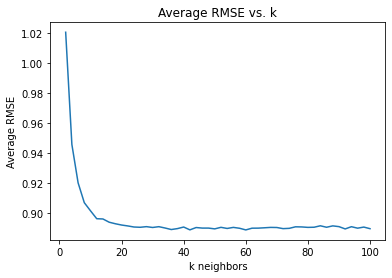

In [ ]:
# plot average RMSE (y-axis) against k (x-axis)

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Average RMSE vs. k")

plt.show()

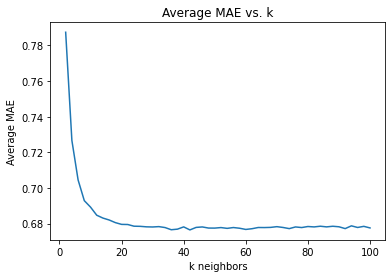

In [ ]:
# plot average MAE (y-axis) against k (x-axis)
plt.plot(k, avg_mae)
plt.xlabel("k neighbors")
plt.ylabel("Average MAE")
plt.title("Average MAE vs. k")
plt.show()

# Trimming the set

In [38]:
# receive data in: ["userId", "movieId", "ratings"]

# Popular movie trimming
    # only movies with more than 2 ratings
def popularMovieTrim(data):
  uniqueMovies = data.movieId.unique() # unique values of movies

  for movie in uniqueMovies:
    ratingCount = data['movieId'].value_counts()[movie]
    if ratingCount<3:
      data = data.loc[data["movieId"] != movie]

  return data

# Unpopular movie trimming
    # only movies with less than or equal to 2 ratings
def unpopularMovieTrim(data):
  uniqueMovies = data.movieId.unique()

  for movie in uniqueMovies:
    ratingCount = data['movieId'].value_counts()[movie]
    if ratingCount>2:
      data = data.loc[data["movieId"] != movie]

  return data

# High variance movie trimming
    # movies with at least 5 ratings 
        # movies that have rating variance of at least 2
def highVarianceMovieTrim(data):
  uniqueMovies = data.movieId.unique() # unique values of movies

  for movie in uniqueMovies:
    ratingCount = data['movieId'].value_counts()[movie]
    if ratingCount<5:
      data = data.loc[data["movieId"] != movie]
    
  uniqueMovies2 = data.movieId.unique()
  for movie in uniqueMovies2:
    byMovieID = data.loc[data['movieId'] == movie]
    variance = np.var(byMovieID['rating'])
    if variance<2:
      data = data.loc[data["movieId"] != movie]
                       
  return data

# Question 6

In [ ]:
ratings = ratings.drop(columns=["Unnamed: 0", "timestamp"])

## No Trimming

In [ ]:
ratings

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5
...,...,...,...
100831,469,1219,4.0
100832,599,3571,2.0
100833,414,276,3.0
100834,395,168,3.0


In [ ]:
# (1) trimming: 

data=ratings

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,100+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  pearsonKNN = KNNWithMeans(k=neighbors, sim_options=pearson_Sim, verbose=False) # with means centers around means
  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    pearsonKNN.fit(trainset)
    predictions = pearsonKNN.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50

K52

K54

K56

K58

K60

K62

K64

K66

K68

K70

K72

K74

K76

K78

K80

K82

K84

K86

K88

K90

K92

K94

K96

K98

K100


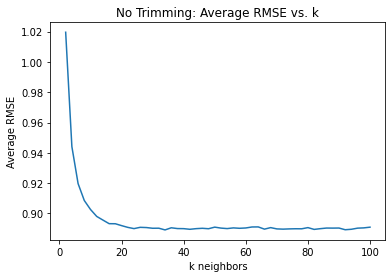

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("No Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 20

Average RMSE: 0.8910136771553069
Threshold value: 2.5


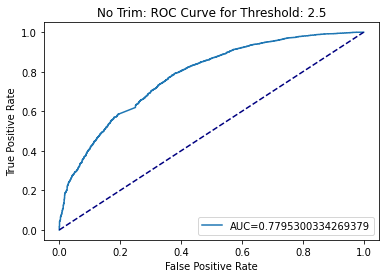

Threshold value: 3


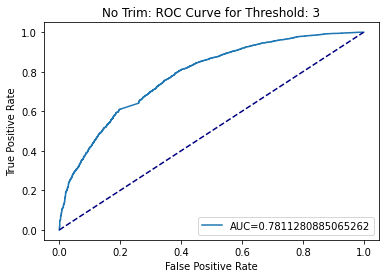

Threshold value: 3.5


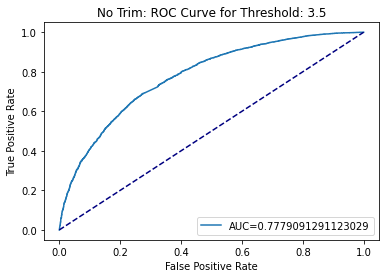

Threshold value: 4


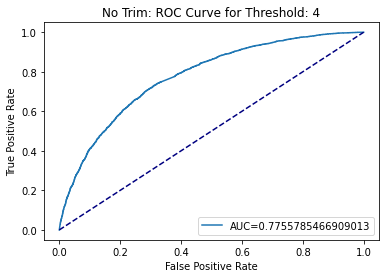

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (10%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

pearsonKNN = KNNWithMeans(k=minK, sim_options=pearson_Sim, verbose=False) # with means centers around means

pearsonKNN.fit(trainset)
predictions = pearsonKNN.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("No Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


## Popular Movie Trimming

In [ ]:
ratings

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5
...,...,...,...
100831,469,1219,4.0
100832,599,3571,2.0
100833,414,276,3.0
100834,395,168,3.0


In [ ]:
# (1) trimming: 

data=popularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,100+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  pearsonKNN = KNNWithMeans(k=neighbors, sim_options=pearson_Sim, verbose=False) # with means centers around means
  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    pearsonKNN.fit(trainset)
    predictions = pearsonKNN.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50

K52

K54

K56

K58

K60

K62

K64

K66

K68

K70

K72

K74

K76

K78

K80

K82

K84

K86

K88

K90

K92

K94

K96

K98

K100


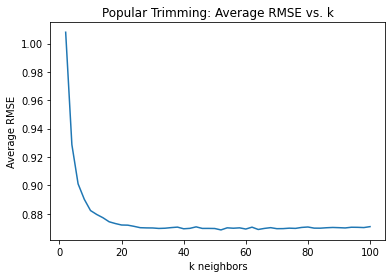

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Popular Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 20

Average RMSE: 0.8769152979060402
Threshold value: 2.5


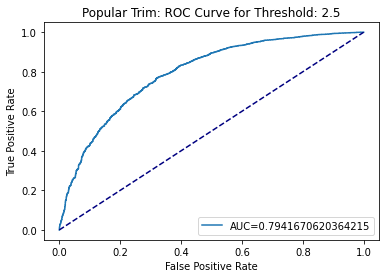

Threshold value: 3


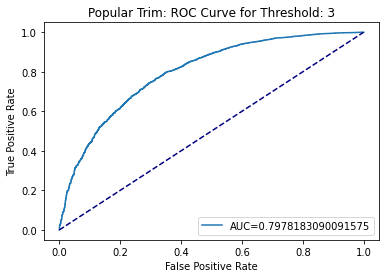

Threshold value: 3.5


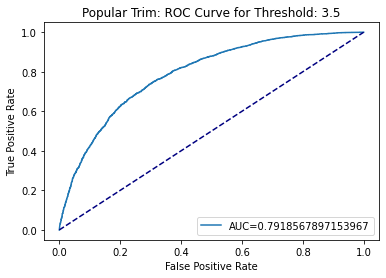

Threshold value: 4


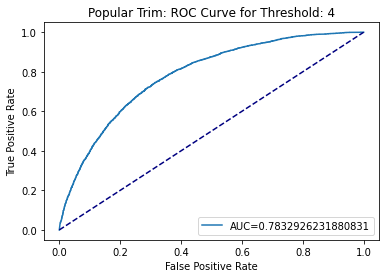

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

pearsonKNN = KNNWithMeans(k=minK, sim_options=pearson_Sim, verbose=False) # with means centers around means

pearsonKNN.fit(trainset)
predictions = pearsonKNN.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Popular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


##Unpopular Movie Trimming

In [ ]:
ratings

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5
...,...,...,...
100831,469,1219,4.0
100832,599,3571,2.0
100833,414,276,3.0
100834,395,168,3.0


In [ ]:
# (1) trimming: 

data=unpopularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,100+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  pearsonKNN = KNNWithMeans(k=neighbors, sim_options=pearson_Sim, verbose=False) # with means centers around means
  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    pearsonKNN.fit(trainset)
    predictions = pearsonKNN.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50

K52

K54

K56

K58

K60

K62

K64

K66

K68

K70

K72

K74

K76

K78

K80

K82

K84

K86

K88

K90

K92

K94

K96

K98

K100


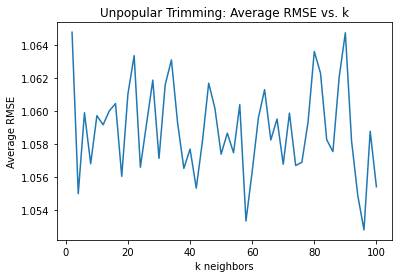

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Unpopular Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 58

Average RMSE: 1.024236799218141
Threshold value: 2.5


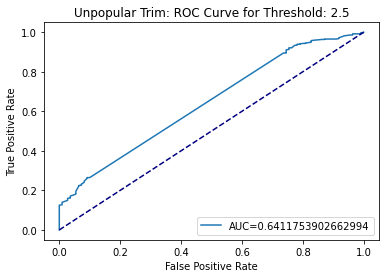

Threshold value: 3


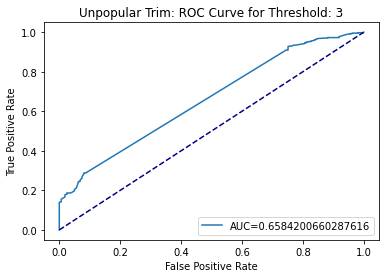

Threshold value: 3.5


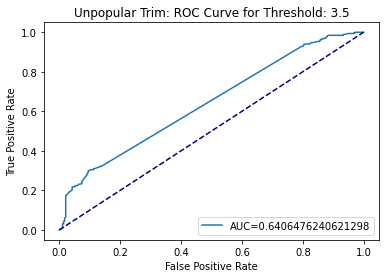

Threshold value: 4


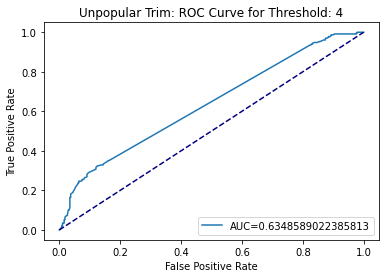

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

pearsonKNN = KNNWithMeans(k=minK, sim_options=pearson_Sim, verbose=False) # with means centers around means

pearsonKNN.fit(trainset)
predictions = pearsonKNN.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Unpopular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


## High Variance Movie Trimming

In [ ]:
ratings

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5
...,...,...,...
100831,469,1219,4.0
100832,599,3571,2.0
100833,414,276,3.0
100834,395,168,3.0


In [ ]:
# (1) trimming: 

data=highVarianceMovieTrim(ratings)

In [ ]:
data.size

750

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,100+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  pearsonKNN = KNNWithMeans(k=neighbors, sim_options=pearson_Sim, verbose=False) # with means centers around means
  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    pearsonKNN.fit(trainset)
    predictions = pearsonKNN.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50

K52

K54

K56

K58

K60

K62

K64

K66

K68

K70

K72

K74

K76

K78

K80

K82

K84

K86

K88

K90

K92

K94

K96

K98

K100


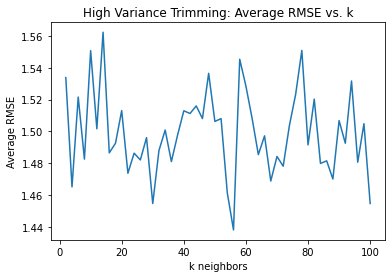

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("High Variance Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 58

Average RMSE: 1.5744376696133786
Threshold value: 2.5


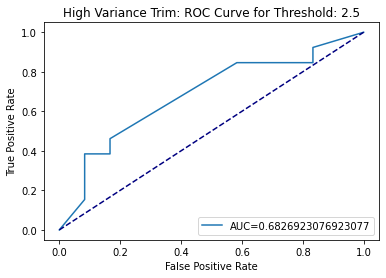

Threshold value: 3


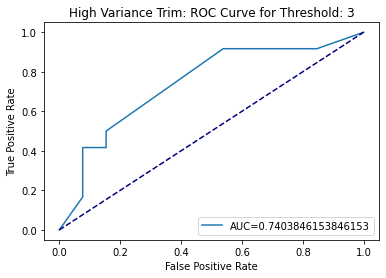

Threshold value: 3.5


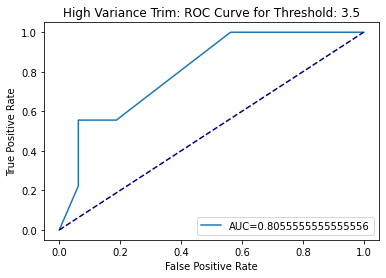

Threshold value: 4


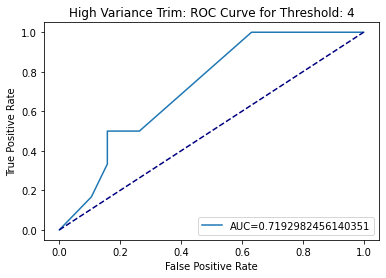

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

pearsonKNN = KNNWithMeans(k=minK, sim_options=pearson_Sim, verbose=False) # with means centers around means

pearsonKNN.fit(trainset)
predictions = pearsonKNN.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("High Variance Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


# Question 8

## Part a

In [ ]:
ratings = ratings.drop(columns=["Unnamed: 0", "timestamp"])

KeyError: ignored

In [ ]:
ratings.head()

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5


In [ ]:
k = range(2,50+1, 2)
avg_rmse = []
avg_mae = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(ratings, reader=reader)

In [ ]:
# NMF-based collaborative filter
    # 10-fold cross validation
    # sweep k (number of latent factors) from [2,50] (step size = 2)
    # compute average RMSE and average MAE
    # plot RMSE and MAE against k
    # use default regularization parameter
    
for neighbors in k:
  print("\nK" + str(neighbors))

  nmfCollab = NMF(n_factors=neighbors)

  cv = cross_validate(nmfCollab, data=ratings_data,  measures=['rmse', 'mae'], cv=10, return_train_measures=False, verbose=True)
  avg_rmse.append(np.mean(cv['test_rmse']))
  avg_mae.append(np.mean(cv['test_mae']))


K2
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1408  1.1471  1.1403  1.1548  1.1496  1.1512  1.1515  1.1421  1.1487  1.1534  1.1479  0.0050  
MAE (testset)     0.9556  0.9652  0.9630  0.9695  0.9691  0.9686  0.9677  0.9601  0.9637  0.9667  0.9649  0.0042  
Fit time          2.43    4.89    4.13    3.35    2.23    2.93    2.08    2.28    2.30    2.14    2.88    0.91    
Test time         0.15    0.13    0.40    0.06    0.05    0.15    0.06    0.21    0.05    0.05    0.13    0.10    

K4
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0349  1.0296  1.0407  1.0509  1.0378  1.0493  1.0323  1.0401  1.0448  1.0297  1.0390  0.0072  
MAE (testset)     0.8424  0.8416  0.8509  0.8572  0.8473  0.8597  0.8421  0.8

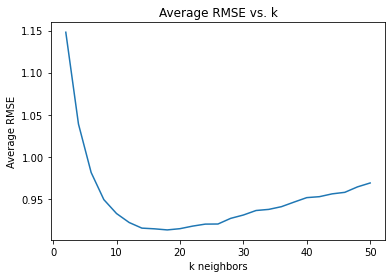

In [ ]:
# plot average RMSE (y-axis) against k (x-axis)

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Average RMSE vs. k")

plt.show()

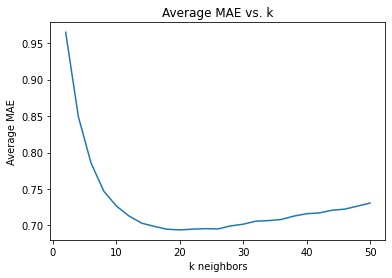

In [ ]:
# plot average MAE (y-axis) against k (x-axis)
plt.plot(k, avg_mae)
plt.xlabel("k neighbors")
plt.ylabel("Average MAE")
plt.title("Average MAE vs. k")
plt.show()

## Part c

### Popular Trimmed

In [ ]:
# (1) trimming: 

data=popularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  nmfCollab = NMF(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    nmfCollab.fit(trainset)
    predictions = nmfCollab.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


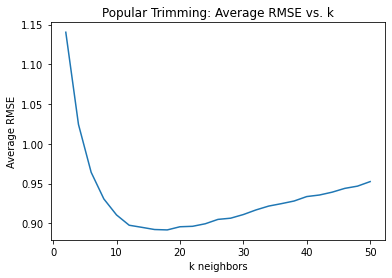

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Popular Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 17

Average RMSE: 0.9017404317936222
Threshold value: 2.5


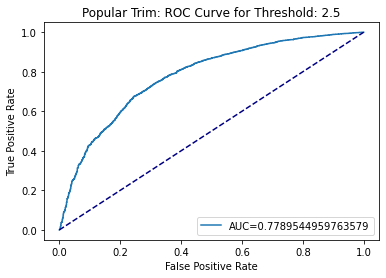

Threshold value: 3


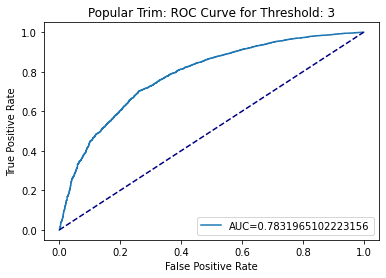

Threshold value: 3.5


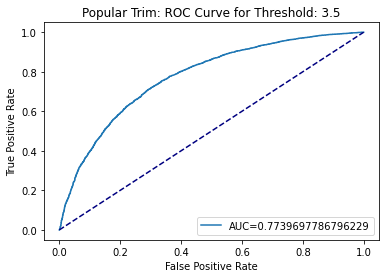

Threshold value: 4


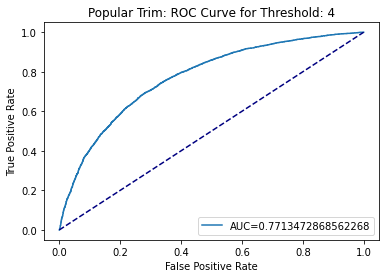

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

nmfCollab = NMF(n_factors=minK)

nmfCollab.fit(trainset)
predictions = nmfCollab.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Popular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


### Unpopular Trimmed

In [ ]:
# (1) trimming: 

data=unpopularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  nmfCollab = NMF(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    nmfCollab.fit(trainset)
    predictions = nmfCollab.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


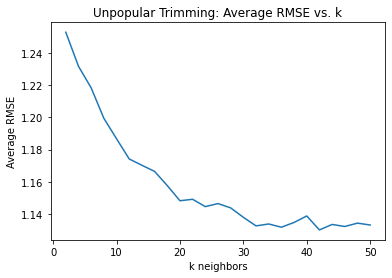

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Unpopular Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 50

Average RMSE: 1.1172355178279296
Threshold value: 2.5


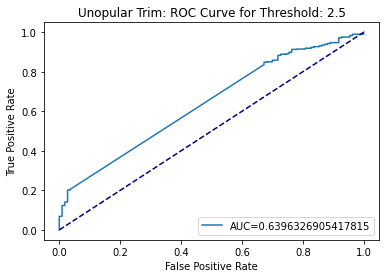

Threshold value: 3


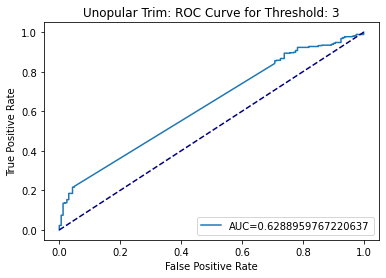

Threshold value: 3.5


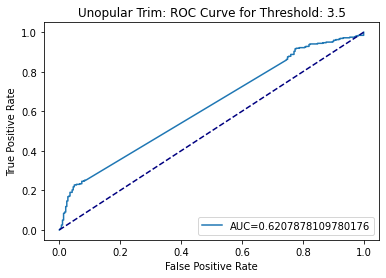

Threshold value: 4


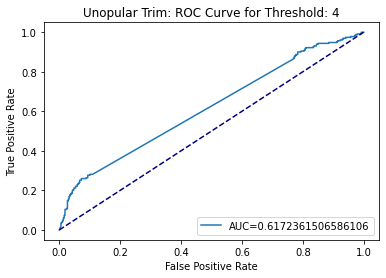

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

nmfCollab = NMF(n_factors=minK)

nmfCollab.fit(trainset)
predictions = nmfCollab.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Unopular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


### High-Variance Trimmed

In [ ]:
# (1) trimming: 

data=highVarianceMovieTrim(ratings)

In [ ]:
data.size

750

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  nmfCollab = NMF(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    nmfCollab.fit(trainset)
    predictions = nmfCollab.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


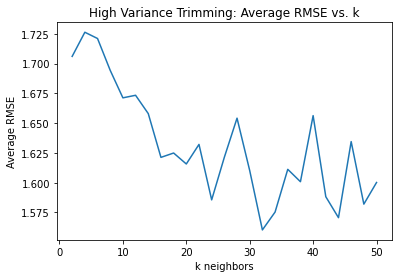

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("High Variance Trimming: Average RMSE vs. k")

plt.show()

In [ ]:
# (4) report minimum k and its average RMSE
minK = 32

Average RMSE: 1.6243770814227494
Threshold value: 2.5


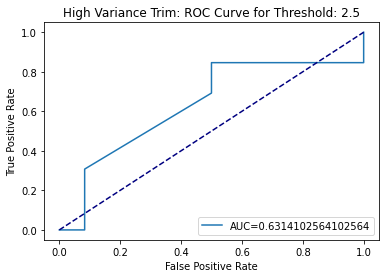

Threshold value: 3


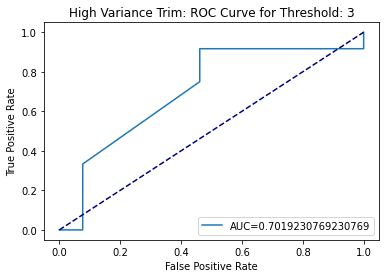

Threshold value: 3.5


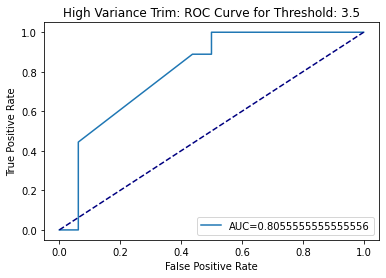

Threshold value: 4


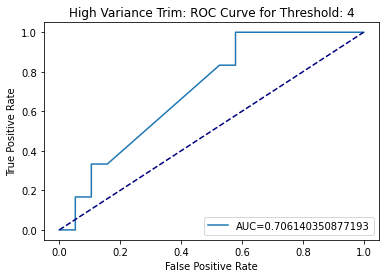

In [ ]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

nmfCollab = NMF(n_factors=minK)

nmfCollab.fit(trainset)
predictions = nmfCollab.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("High Variance Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


# Question 9

In [43]:
from google.colab import files
uploaded = files.upload()

import io
movies = pd.read_csv(io.BytesIO(uploaded['movies.csv']))

Saving movies.csv to movies.csv


In [44]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [41]:
# perform NMF on ratings matrix R to obtain U and V 
    # U = user-latent factors interaction
    # V = movie-latent factors interaction 
    # k=20 latent factors

# for each column of V, sort the movies in descending order (in highest rating)
# report the genres of top 10 movies 

k=20

data = ratings
reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)
trainset = ratings_data.build_full_trainset()

nmfCollab = NMF(n_factors=k, verbose=False)
nmfCollab.fit(trainset) # fit on the entire set
V = nmfCollab.qi # movie factors, array of size (n_movies, n_factors)

In [23]:
V.shape

(9724, 20)

In [54]:
for column in range(0,20):
  print("\nColumn: " + str(column))
  movies_in_V = V[:,column]
  topMovie = [(i,j) for i,j in enumerate(movies_in_V)]
  topMovie.sort(key = lambda x:x[1], reverse=True)

  for genreList in topMovie[:10]:
    print(movies['genres'][genreList[0]])


Column: 0
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thriller
Adventure|Children|Comedy
Drama|Thriller
Comedy
Action|Drama|War
Drama|Romance
Action|Adventure|Thriller

Column: 1
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thriller
Adventure|Children|Comedy
Drama|Thriller
Comedy
Action|Drama|War
Drama|Romance
Action|Adventure|Thriller

Column: 2
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thriller
Adventure|Children|Comedy
Drama|Thriller
Comedy
Action|Drama|War
Drama|Romance
Action|Adventure|Thriller

Column: 3
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thriller
Adventure|Children|Comedy
Drama|Thriller
Comedy
Action|Drama|War
Drama|Romance
Action|Adventure|Thriller

Column: 4
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thriller
Adventure|Children|Comedy
Drama|Thriller
Comedy
Action|Drama|War
Drama|Romance
Action|Adventure|Thriller

Column: 5
Drama
Drama|Romance|War
Comedy|Drama|Romance
Horror|Mystery|Thri

# Question 10

## Part A

In [ ]:
k = range(2,50+1, 2)
avg_rmse = []
avg_mae = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(ratings, reader=reader)

In [ ]:
# matrix factorization with bias
    # 10 fold cross validation
    # sweep k from [2,50]
    # compute average RMSE and MAE
    # plot RMSE and MAE vs. k
    # use default regularization

for neighbors in k:
  print("\nK" + str(neighbors))

  mfBias = SVD(n_factors=neighbors)

  cv = cross_validate(mfBias, data=ratings_data,  measures=['rmse', 'mae'], cv=10, return_train_measures=False, verbose=True)
  avg_rmse.append(np.mean(cv['test_rmse']))
  avg_mae.append(np.mean(cv['test_mae']))


K2
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8648  0.8843  0.8691  0.8662  0.8519  0.8588  0.8654  0.8747  0.8574  0.8731  0.8666  0.0089  
MAE (testset)     0.6601  0.6774  0.6655  0.6639  0.6590  0.6623  0.6671  0.6719  0.6583  0.6714  0.6657  0.0059  
Fit time          0.96    0.68    0.66    0.66    0.96    2.07    1.15    1.32    0.94    0.80    1.02    0.40    
Test time         0.17    0.12    0.07    0.08    0.14    0.10    0.26    0.14    0.11    0.17    0.14    0.05    

K4
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8748  0.8649  0.8643  0.8717  0.8611  0.8644  0.8669  0.8613  0.8753  0.8601  0.8665  0.0053  
MAE (testset)     0.6717  0.6634  0.6643  0.6727  0.6634  0.6662  0.6635  0.6

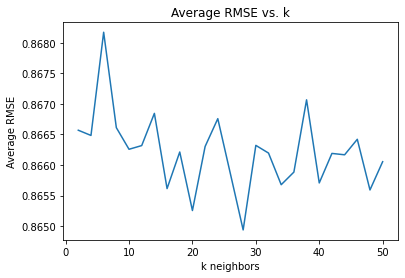

In [ ]:
# plot average RMSE (y-axis) against k (x-axis)

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Average RMSE vs. k")

plt.show()

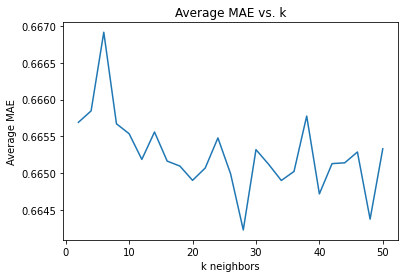

In [ ]:
# plot average MAE (y-axis) against k (x-axis)
plt.plot(k, avg_mae)
plt.xlabel("k neighbors")
plt.ylabel("Average MAE")
plt.title("Average MAE vs. k")
plt.show()

## Part c

### Popular Trimmed

In [91]:
# (1) trimming: 

data=popularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  mfBias = SVD(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    mfBias.fit(trainset)
    predictions = mfBias.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


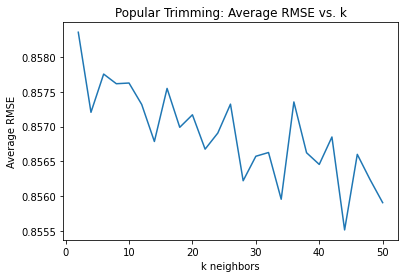

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Popular Trimming: Average RMSE vs. k")

plt.show()

In [92]:
# (4) report minimum k and its average RMSE
minK = 44

Average RMSE: 0.8661633220709095
Threshold value: 2.5


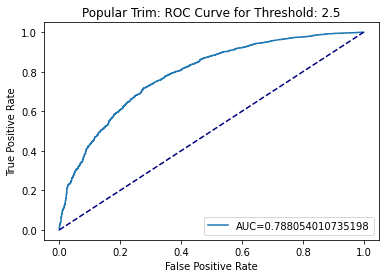

Threshold value: 3


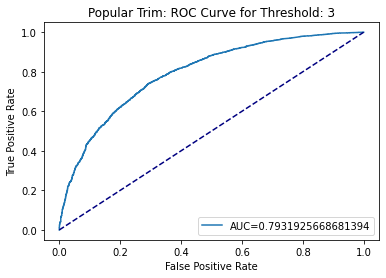

Threshold value: 3.5


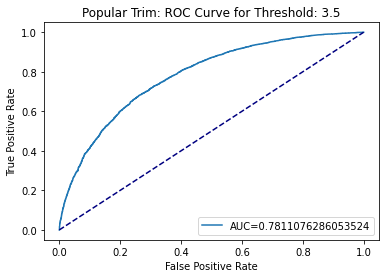

Threshold value: 4


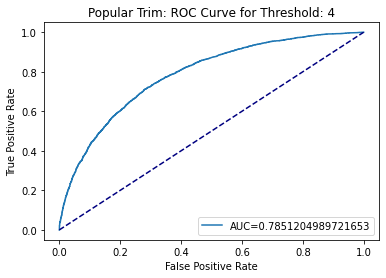

In [94]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

mfBias = SVD(n_factors=minK)

mfBias.fit(trainset)
predictions = mfBias.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Popular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


### Unpopular Trimmed

In [101]:
# (1) trimming: 

data=unpopularMovieTrim(ratings)

In [ ]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  mfBias = SVD(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    mfBias.fit(trainset)
    predictions = mfBias.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


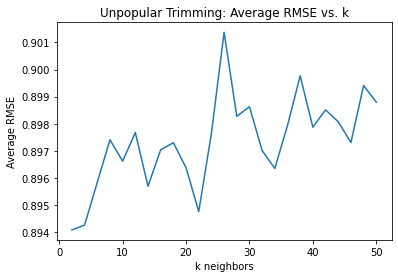

In [ ]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("Unpopular Trimming: Average RMSE vs. k")

plt.show()

In [96]:
# (4) report minimum k and its average RMSE
minK = 3

Average RMSE: 0.8559783020976404
Threshold value: 2.5


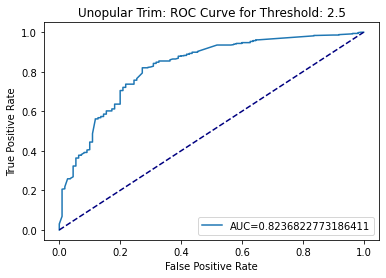

Threshold value: 3


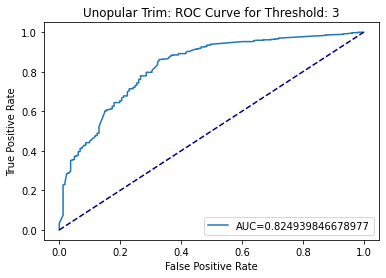

Threshold value: 3.5


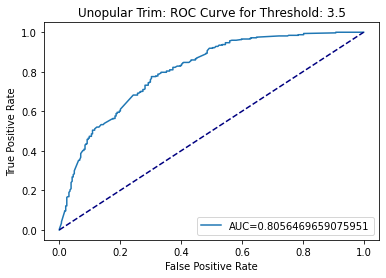

Threshold value: 4


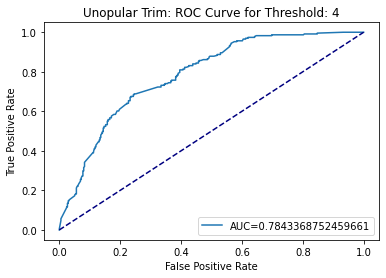

In [102]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value
reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

mfBias = SVD(n_factors=minK)

mfBias.fit(trainset)
predictions = mfBias.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("Unopular Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


### High-Variance Trimmed

In [106]:
# (1) trimming: 

data=highVarianceMovieTrim(ratings)

In [107]:
# (2) KNN collab filter
    # evaluate performance using 10-fold CV
    # sweep k=[2,100] (step size=2)
    # compute average RMSE

k = range(2,50+1, 2)
avg_rmse = []

pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
}

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)


for neighbors in k:
  print("\nK" + str(neighbors))

  mfBias = SVD(n_factors=neighbors)

  kf = KFold(n_splits=10)

  rmse = []
  for trainset, testset in kf.split(ratings_data):
    mfBias.fit(trainset)
    predictions = mfBias.test(testset)
    rmse.append(accuracy.rmse(predictions, verbose=False))
  
  avg_rmse.append(np.mean(rmse))


K2

K4

K6

K8

K10

K12

K14

K16

K18

K20

K22

K24

K26

K28

K30

K32

K34

K36

K38

K40

K42

K44

K46

K48

K50


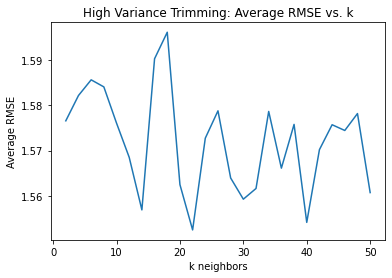

In [108]:
# (3) plot average RMSE against k

plt.plot(k, avg_rmse)
plt.xlabel("k neighbors")
plt.ylabel("Average RMSE")
plt.title("High Variance Trimming: Average RMSE vs. k")

plt.show()

In [109]:
# (4) report minimum k and its average RMSE
minK = 22

Average RMSE: 1.5759537977965496
Threshold value: 2.5


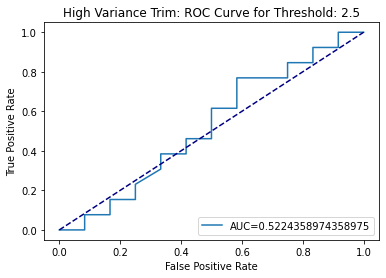

Threshold value: 3


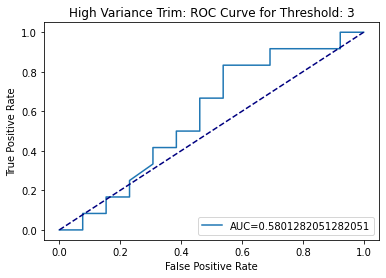

Threshold value: 3.5


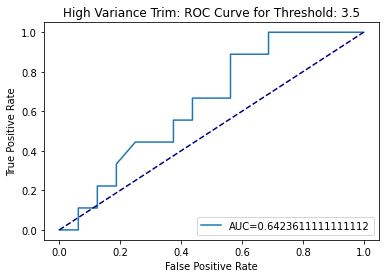

Threshold value: 4


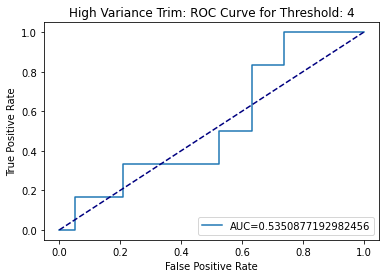

In [110]:
# (5) plot ROC curve for each threshold value:
    # threshold = [2.5, 3, 3.5, 4]
        # apply to ground truth labels in held-out validation set
    # report AUC value


reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(data, reader=reader)

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

mfBias = SVD(n_factors=minK)

mfBias.fit(trainset)
predictions = mfBias.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [2.5, 3, 3.5, 4]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("High Variance Trim: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


# Question 11

In [39]:
# design a naive collab filter
    # evaluate performance using 10-fold CV
    # compute average RMSE and report it

# prediction function: return the mean rating of the user as it's predicted rating for an item
    # prediction = all ratings for that user / # of ratings the user made
# no notion of training, just use the valdiation set

def naiveFilter(data):

  pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
  }

  reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
  ratings_data = surprise.Dataset.load_from_df(data, reader=reader)

  kf = KFold(n_splits=10)
  rmse = []

  for trainset, testset in kf.split(ratings_data):
    means = np.empty(610)
    for user in range(len(trainset.ur)):
      user_id = trainset.to_raw_uid(user)
      user_mean = np.mean(np.array(trainset.ur[user])[:,1])
      means[user_id-1] = user_mean
    
    y_pred = []
    for i in range(len(testset)):
      userIndex = testset[i][0]
      y_pred.append(means[userIndex-1])
    
    y_true = np.array([i[2] for i in testset])

    rmse.append(np.sqrt(mean_squared_error(y_true,y_pred)))

  avg_rmse = np.mean(rmse)
  print("Average RMSE: " + str(avg_rmse))

In [41]:
# No trim
print("No trim:")
naiveFilter(ratings)

No trim:
Average RMSE: 0.9410519556984109


In [42]:
# Popular
print("Popular trim:")
popularData = popularMovieTrim(ratings)
naiveFilter(popularData)

Popular trim:
Average RMSE: 0.9376202968550311


In [43]:
# Unpopular
print("Unpopular trim:")
unpopularData = unpopularMovieTrim(ratings)
naiveFilter(unpopularData)

Unpopular trim:
Average RMSE: 1.0198618036753762


In [45]:
highVarianceData = highVarianceMovieTrim(ratings)

In [56]:
# High variance
pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
  }

reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
ratings_data = surprise.Dataset.load_from_df(highVarianceData, reader=reader)

kf = KFold(n_splits=10)
rmse = []

for trainset, testset in kf.split(ratings_data):
  means = np.empty(610)
  for user in range(len(trainset.ur)):
    user_id = trainset.to_raw_uid(user)
    user_mean = np.mean(np.array(trainset.ur[user])[:,1])
    means[user_id-1] = user_mean
    
  y_pred = []
  for i in range(len(testset)):
    userIndex = testset[i][0]
    y_pred.append(means[userIndex-1])
    
  y_true = np.array([i[2] for i in testset])
  print(len(y_pred))
  print(len(y_true))

  rmse.append(np.sqrt(mean_squared_error(y_true,y_pred)))

avg_rmse = np.mean(rmse)
print("Average RMSE: " + str(avg_rmse))

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
Average RMSE: 1.1113117513991662


# Question 12

Average RMSE: 0.8910136771553069
Threshold value: 3


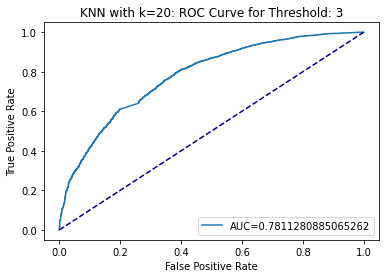

Average RMSE: 0.9161861277754252
Threshold value: 3


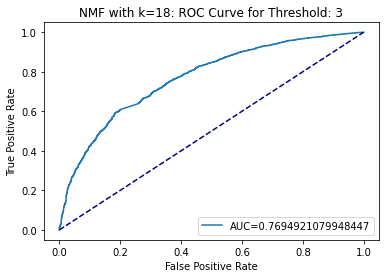

Average RMSE: 0.8674998266046834
Threshold value: 3


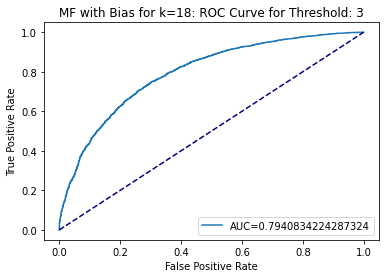

In [ ]:
# plot the best ROC curves (threshold =3)


################### KNN

# split into train (90%) and test (10%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

pearsonKNN = KNNWithMeans(k=20, sim_options=pearson_Sim, verbose=False) # with means centers around means

pearsonKNN.fit(trainset)
predictions = pearsonKNN.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [3]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("KNN with k=20: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()


############# NMF

# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

nmfCollab = NMF(n_factors=18)

nmfCollab.fit(trainset)
predictions = nmfCollab.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [3]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("NMF with k=18: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()



############ MF with bias based collab


# split into train (90%) and test (90%)
trainset, testset = train_test_split(ratings_data, test_size=0.1, train_size=0.9, random_state=42)

mfBias = SVD(n_factors=18)

mfBias.fit(trainset)
predictions = mfBias.test(testset)
print("Average RMSE: " + str(accuracy.rmse(predictions, verbose=False)))

# THRESHOLD THE HELD-OUT VALIDATION SET

thresholdValues = [3]
for thresh in thresholdValues:

  print("Threshold value: " + str(thresh))

  y_true = []
  for i in predictions:
    if i.r_ui<thresh: # actual score binarized
      y_true.append(0)
    else:
      y_true.append(1)
    
  y_score = [i.est for i in predictions] # prediction (no thresholding)

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title("MF with Bias for k=18: ROC Curve for Threshold: " + str(thresh))
  plt.legend(loc=4)

  plt.show()



# Question 14

##KNN

In [111]:
# S(t) = set of items recommended to the user
# G = set of items liked by the user (ground-true)

# (1) use threshold = 3 and best k to get G

# (1.5) if |G|=0 for some user in the validation step, then drop this user

# ranking predictions

# for each user...
    # (1) compute predicted ratings using collab filtering
        # L = predicted ratings
    # (2) sort list in descending order (highest predicted ratings first)
    # (3) select first t-items from the sorted list to recommend to the user

# FOR EACH t [1,25]  (step size 1):
  # (2) compute precision and recall for each fold --> append to list
  # (3) average over 10 folds to get the average precision and recall for the specific t

# (4) plot average precision (Y) against t (X)

# (5) plot average recall against t

# (6) plot average precision (Y) against average recall (X)

In [113]:
def precisionAndRecall(algorithm):
  if(algorithm == "KNN"):
    pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
    }
    alg = KNNWithMeans(k=20, sim_options=pearson_Sim, verbose=False)
  elif (algorithm == "NMF"):
    alg = NMF(n_factors=18)
  elif(algorithm== "MF"):
    alg = SVD(n_factors=18)
  
  pearson_Sim = {
    "name": "pearson", 
    "user_based": True, # compute similarities between users
  }

  reader = surprise.Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
  ratings_data = surprise.Dataset.load_from_df(ratings, reader=reader)

  t_values = range(1,26,1)

  kf = KFold(n_splits=10)
  threshold = 3

  precision_arr = collections.defaultdict(list)
  recall_arr = collections.defaultdict(list)

  for trainset,testset in kf.split(ratings_data):
    precision_fold = collections.defaultdict(list) # precision for this speicifc fold
    recall_fold = collections.defaultdict(list)

    alg.fit(trainset)
    predictions = alg.test(testset)

    unique_ids = set()
    for pred in predictions:
      unique_ids.add(pred.uid)
    
    for id in unique_ids:
      G = set() # set of items liked by user (ground-truth)
      rating_pred = collections.defaultdict(list)
      for pred in predictions:
        if pred.uid != id:
          continue
        if pred.r_ui>threshold: # positive -- liked moive
          G.add(pred.iid)
        
        rating_pred[pred.iid].append(pred.est)
      
      if len(G)==0:
        continue
      
      rankings = sorted(rating_pred.items(), key=lambda x:x[1]) # descending

      for t in t_values:
        S_t = set([x[0] for x in rankings[:t]])

        precision = len(G.intersection(S_t))/t
        recall = len(G.intersection(S_t))/len(G)

        precision_fold[t].append(precision)
        recall_fold[t].append(recall)
    
    for k, v in precision_fold.items():
      precision_arr[k].append(np.mean(v))
    for k, v in recall_fold.items():
      recall_arr[k].append(np.mean(v))

  avg_precision = [np.mean(x[1]) for x in precision_arr.items()]
  avg_recall = [np.mean(x[1]) for x in recall_arr.items()]

  plt.plot(t_values, avg_precision)
  plt.title("Average Precision vs. t")
  plt.xlabel("t")
  plt.ylabel("Average Precision")
  plt.figure()

  plt.plot(t_values, avg_recall)
  plt.title("Average Recall vs. t")
  plt.xlabel("t")
  plt.ylabel("Average Recall")
  plt.figure()

  plt.plot(avg_recall, avg_precision)
  plt.title("Precision vs. Recall")
  plt.xlabel("Average Recall")
  plt.ylabel("Average Precision")

  return avg_precision, avg_recall


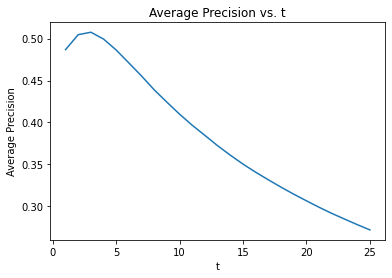

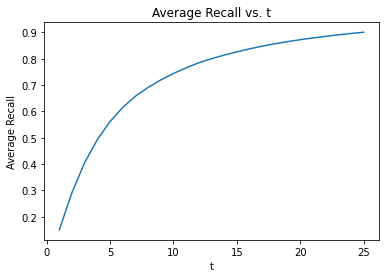

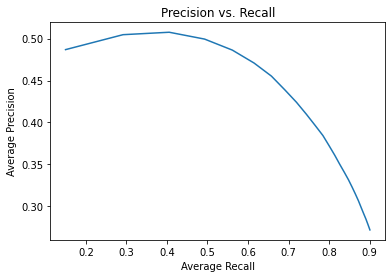

In [114]:
precisionKNN, recallKNN = precisionAndRecall("KNN")

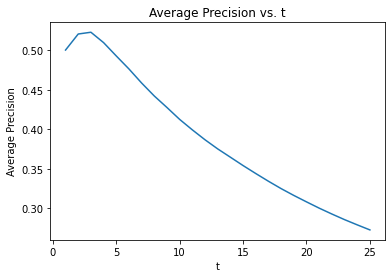

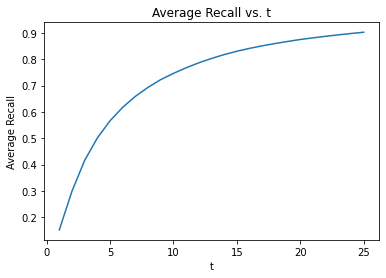

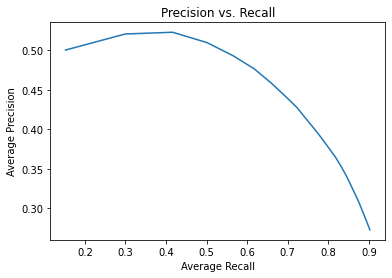

In [115]:
precisionNMF, recallNMF = precisionAndRecall("NMF")

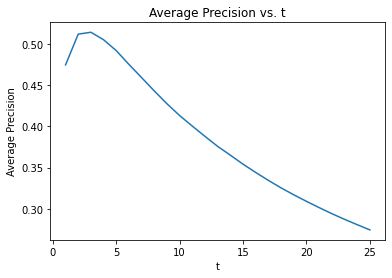

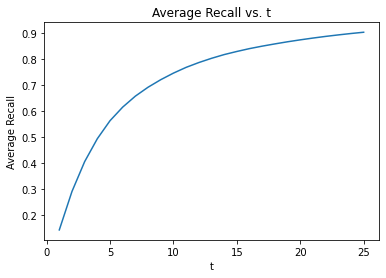

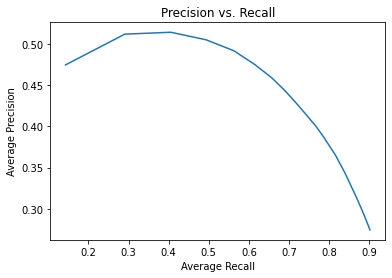

In [116]:
precisionMF, recallMF = precisionAndRecall("MF")

Text(0, 0.5, 'Average Precision')

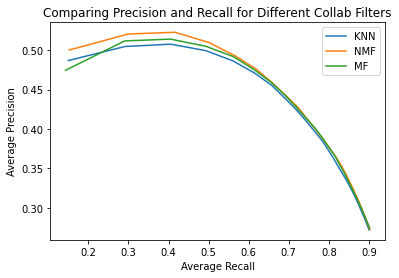

In [117]:
plt.plot(recallKNN, precisionKNN, label='KNN')
plt.plot(recallNMF, precisionNMF, label='NMF')
plt.plot(recallMF, precisionMF, label='MF')
plt.legend()
plt.title("Comparing Precision and Recall for Different Collab Filters")
plt.xlabel("Average Recall")
plt.ylabel("Average Precision")